In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv',encoding='utf8')

In [3]:
raw_data.head(1)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.5,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

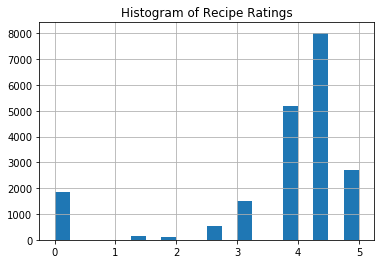

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [11]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

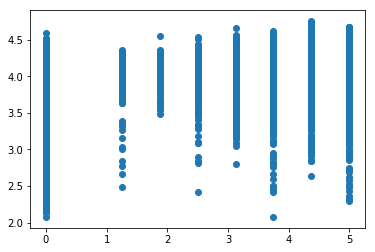

In [12]:
plt.scatter(Y, svr.predict(X))
plt.show()

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [13]:
svr.score(X, Y)

0.03856570651298896

In [14]:
cross_val_score(svr, X, Y, cv=5)

array([0.01818511, 0.026411  , 0.03037705, 0.01957949, 0.02451197])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

1. Clean up the feature set down to the 30 most valuable features
2. Transform this regression problem into a binary classifier grouping reviews to some decided high and low values
    - high >= 4.375
    - low < 4.375

## Create a categegorical column for high/low ratings
Ratings above 4.375 are considered high and receive value 1. Lower ratings receive value 0.

In [15]:
# Create the column:
raw_data['high_rating'] = raw_data.rating
raw_data.high_rating = raw_data.high_rating.apply(lambda x: 0 if x<4.375 else 1)

In [16]:
# Inspect feature balance:
raw_data.high_rating.value_counts()

1    10738
0     9314
Name: high_rating, dtype: int64

## Run SelectKBest to select the 30 most valuable features

In [17]:
# Select the 30 best features using ANOVA f-value as the score-function:
Yc = raw_data.high_rating
kbest = SelectKBest(f_classif, k=30).fit(X, Yc)

# return a boolean array for every feature, true if one of the k best features, false if not:
mask = kbest.get_support()

# vizualize the kbest features:
new_features = X.columns[mask]

In [18]:
# Inspect the results:
new_features

Index(['alcoholic', 'backyard bbq', 'bitters', 'bon appétit', 'christmas',
       'cocktail', 'cocktail party', 'dessert', 'dinner', 'drink', 'fall',
       'father's day', 'gin', 'goat cheese', 'grill', 'grill/barbecue',
       'harpercollins', 'house & garden', 'low fat', 'pasta', 'peanut free',
       'roast', 'rum', 'soy free', 'spirit', 'stir-fry', 'stuffing/dressing',
       'thanksgiving', 'tree nut free', 'vegan'],
      dtype='object')

#### Many of the values are not ingredients.

Drop features that are not ingredients and run SelectKBest again:

In [19]:
X_ingredients = X.drop(['alcoholic', 'backyard bbq', 'bitters', 'bon appétit', 'christmas',
       'cocktail', 'cocktail party', 'dessert', 'dinner', 'drink', 'fall',
       'father\'s day', 'gin','grill', 'grill/barbecue',
       'harpercollins', 'house & garden', 'low fat','peanut free',
       'roast', 'rum', 'soy free', 'spirit', 'stir-fry', 'stuffing/dressing',
       'thanksgiving', 'tree nut free', 'vegan', 'bake', 'brisket', 'cake',
       'chartreuse', 'fourth of july', 'fruit', 'gourmet', 'high fiber',
       'liqueur', 'low carb', 'meat','pescatarian', 'quick & easy', 'scotch',
       'vegetable','braise','christmas eve','family reunion','kosher',
       'low/no sugar', 'lunch', 'mixer', 'non-alcoholic', 'weelicious',
       '3-ingredient recipes', 'condiment', 'jícama', 'molasses'],1)

In [20]:
# Re-run SelectKBest
kbest = SelectKBest(f_classif, k=30).fit(X_ingredients, Yc)

# return a boolean array for every feature, true if one of the k best features, false if not:
mask = kbest.get_support()

# vizualize the kbest features:
new_features = X_ingredients.columns[mask]
new_features

Index(['almond', 'arugula', 'banana', 'beef rib', 'berry', 'bread', 'broccoli',
       'cabbage', 'cornmeal', 'cranberry', 'créme de cacao', 'feta', 'fig',
       'goat cheese', 'ground lamb', 'lamb', 'pasta', 'pastry', 'pomegranate',
       'pork', 'pork tenderloin', 'radish', 'red wine', 'rosemary', 'sausage',
       'steak', 'tofu', 'yogurt', 'zucchini', 'turkey'],
      dtype='object')

In [21]:
# Filter a matrix with only the k best features:
X_kbest = kbest.transform(X_ingredients)

In [22]:
print('original dataframe shape:',X.shape)
print('k best dataframe shape:',X_kbest.shape)

original dataframe shape: (20052, 674)
k best dataframe shape: (20052, 30)


## Run the SVM Classifier with the K Best features

In [23]:
# Call the SMV Classifier method:
clf = svm.SVC()
# Cross-validate and inspect the scores:
cross_val_score(clf, X_kbest, Yc, cv=5)

array([0.54749439, 0.55048616, 0.55148342, 0.5563591 , 0.5527563 ])

## Convert the K Best features to PCA and re-run the SVM Classifier

In [24]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_kbest)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.10553614 0.09814873 0.06311156 0.05848713 0.05617119 0.05180785
 0.04924737 0.04233845 0.03966359 0.0377555  0.03674879 0.03435107
 0.03290438 0.03203622 0.02972114 0.02891814 0.02620354 0.02594383
 0.02488957 0.02247201]


In [25]:
# The sum of the percentage of the total variance explained by PCA with 20 components:
sum(pca.explained_variance_ratio_)

0.8964562109228398

In [39]:
cross_val_score(clf, X_pca[:,:10], Yc, cv=5)

array([0.54400399, 0.54176016, 0.5477437 , 0.54763092, 0.55026191])

## Tune the SVM parameters using GridSearchCV

In [27]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10],
              'decision_function_shape':('ovr','ovo')}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_kbest, Yc)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10], 'decision_function_shape': ('ovo', 'ovr')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
# Inspect scores and optimal parameters:
clf.grid_scores_

[mean: 0.55635, std: 0.00209, params: {'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'linear'},
 mean: 0.55042, std: 0.00158, params: {'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'},
 mean: 0.55635, std: 0.00209, params: {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'linear'},
 mean: 0.55042, std: 0.00158, params: {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'rbf'},
 mean: 0.55635, std: 0.00209, params: {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'linear'},
 mean: 0.55635, std: 0.00209, params: {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'rbf'},
 mean: 0.55635, std: 0.00209, params: {'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'linear'},
 mean: 0.55635, std: 0.00209, params: {'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}]

In [34]:
# Run GridSearchCV again, with the gamma parameter:
parameters = {'C':[1, 10], 'gamma':[3, 30]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_kbest, Yc)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10], 'gamma': [0.03, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
# Inspect scores and optimal parameters:
clf.grid_scores_

[mean: 0.55012, std: 0.00156, params: {'C': 1, 'gamma': 0.03},
 mean: 0.55785, std: 0.00222, params: {'C': 1, 'gamma': 3},
 mean: 0.55556, std: 0.00246, params: {'C': 10, 'gamma': 0.03},
 mean: 0.55795, std: 0.00226, params: {'C': 10, 'gamma': 3}]

The linear kernel and C = 10 parameters seem to have slightly better results.

### Cross-validate again, now with selected parameters and PCA

In [38]:
# Call the SMV Classifier method:
clf = svm.SVC(C=10, kernel='linear', gamma=3)
# Cross-validate with the top 10 PCA features and inspect the scores:
cross_val_score(clf, X_pca[:,:10], Yc, cv=5)

array([0.54400399, 0.54176016, 0.5477437 , 0.54763092, 0.55026191])

Using PCA reduces the number of features from 30 to 10 without significant differences in scores.

### Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

Most of the original K Best features were related to alcoholic ingredients or celebration recipies (e.g., 'christmas' or 'cocktail party'). Possibly, users that don't cook often (only on holidays) and give higher ratings.